**Домашнее задание**
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier as xgb
from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_error

Для примера выберем <a href="https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope">датасет регистрации гамма-частиц с помощью астрономического телескопа</a>. На его основе будут выполнены задания дальше.

In [2]:
with open('magic04.names') as f:
    print(f.read())

1. Title of Database: MAGIC gamma telescope data 2004

2. Sources:

   (a) Original owner of the database:

       R. K. Bock
       Major Atmospheric Gamma Imaging Cherenkov Telescope project (MAGIC)
       http://wwwmagic.mppmu.mpg.de
       rkb@mail.cern.ch

   (b) Donor:

       P. Savicky
       Institute of Computer Science, AS of CR
       Czech Republic
       savicky@cs.cas.cz

   (c) Date received: May 2007

3. Past Usage:

   (a) Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T.,
       Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S.,
       Vaicilius, A., Wittek W. (2004).
       Methods for multidimensional event classification: a case study
       using images from a Cherenkov gamma-ray telescope.
       Nucl.Instr.Meth. A, 516, pp. 511-528.

   (b) P. Savicky, E. Kotrc.
       Experimental Study of Leaf Confidences for Random Forest.
       Proceedings of COMPSTAT 2004, In: Computational Statistics.
       (Ed.: Antoch J.) - Heidelberg, Physi

In [3]:
names = {'fLength':  'continuous  # major axis of ellipse [mm]',
         'fWidth':   'continuous  # minor axis of ellipse [mm]',
         'fSize':    'continuous  # 10-log of sum of content of all pixels [in #phot]',
         'fConc':    'continuous  # ratio of sum of two highest pixels over fSize  [ratio]',
         'fConc1':   'continuous  # ratio of highest pixel over fSize  [ratio]',
         'fAsym':    'continuous  # distance from highest pixel to center, projected onto major axis [mm]',
         'fM3Long':  'continuous  # 3rd root of third moment along major axis  [mm]',
         'fM3Trans': 'continuous  # 3rd root of third moment along minor axis  [mm]',
         'fAlpha':   'continuous  # angle of major axis with vector to origin [deg]',
         'fDist':    'continuous  # distance from origin to center of ellipse [mm]',
         'class':    'g,h         # gamma (signal), hadron (background)'}

In [4]:
df = pd.read_csv('magic04.data', header=None)
df.columns = names.keys()
df['class'] = (df['class'] == 'g').astype('int')
df

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,0
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,0
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,0
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,0


In [5]:
df.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026,0.648370
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787,0.477492
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600,0.000000
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250,0.000000
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450,1.000000
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825,1.000000
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000,1.000000


Датасет выглядит вполне опрятным, попробуем выполнить генерацию признаков в случае, если бейслайн окажется плохим.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='class'),
                                                    df['class'],
                                                    test_size=0.2,
                                                    stratify=df['class'])
model = xgb(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
f1_score(y_train, predict_train), f1_score(y_test, predict_test)

(0.9727634194831014, 0.9048086359175662)

Из-за высоких предварительных F метрик откажемся от дополнительной корректировки состава признаков.

In [164]:
def unlab_makrup(arr, sample_size, label='positive', **kwargs):
    
    arr = arr.copy()
    if label == 'positive':
        arr_idx = arr.copy()[arr==1]
    elif label == 'negative':
        arr_idx = arr.copy()[arr.isna()]
    
    if sample_size < 1:
        sample_size = arr_idx.shape[0] * sample_size
    sample_size = int(sample_size)
    
    np.random.seed(kwargs.get('seed', kwargs.get('random_state', None)))
    arr_idx = np.random.choice(arr_idx.index, size=sample_size, replace=False)
    
    if label == 'positive':
        arr = arr.where(np.isin(arr.index, arr_idx))
    elif label == 'negative':
        arr[arr_idx] = 0
    
    return arr, arr_idx

In [165]:
y_train_pos, train_idx = unlab_makrup(y_train, 0.3, random_state=99)
y_test_pos, test_idx = unlab_makrup(y_test, 0.3, random_state=99)

In [173]:
y_train_pos_neg, _ = unlab_makrup(y_train_pos, 0.1, label='negative', random_state=99)
y_train_pos_neg.value_counts(dropna=False)

NaN    11032
1.0     2959
0.0     1225
Name: class, dtype: int64

In [175]:
idx = ~y_train_pos_neg.isna()

model_unlab = xgb(use_label_encoder=False, eval_metric='logloss')
model_unlab.fit(X_train.loc[idx], y_train_pos_neg[idx])
predict_train_unlab = model_unlab.predict(X_train)
predict_test_unlab = model_unlab.predict(X_test)
f1_score(y_train, predict_train_unlab), f1_score(y_test, predict_test_unlab)

(0.8674104057656236, 0.8738127544097694)

Как видно, метрика страдает не сильно даже при простом случайном выборе нулевых классов.

Узнаем зависимость распределения значений метрики F1 от доли P:

In [178]:
def fit_and_check( P_level):
    
    y_train_pos, _ = unlab_makrup(y_train, P_level, random_state=99)
    y_test_pos, _ = unlab_makrup(y_test, P_level, random_state=99)
    y_train_pos_neg, _ = unlab_makrup(y_train_pos, 0.1, label='negative', random_state=99)
    
    idx = ~y_train_pos_neg.isna()
    model_unlab = xgb(use_label_encoder=False, eval_metric='logloss')
    model_unlab.fit(X_train.loc[idx], y_train_pos_neg[idx])
    
    predict_train_unlab = model_unlab.predict(X_train)
    predict_test_unlab = model_unlab.predict(X_test)
    
    return f1_score(y_train, predict_train_unlab), f1_score(y_test, predict_test_unlab)

In [202]:
df2 = pd.DataFrame(columns=['positive_percent', 'train', 'test'])
iterations = 20
for rate in range(iterations):
    res = fit_and_check(rate / iterations)
    df2 = df2.append({'positive_percent': rate / iterations, 'train': res[0], 'test': res[1]}, ignore_index=True)
df2

,positive_percent,train,test
0,0.00,0.000000,0.000000
1,0.05,0.308794,0.269825
2,0.10,0.630983,0.619136
3,0.15,0.756355,0.749598
4,0.20,0.816327,0.822269
5,0.25,0.847504,0.856166
6,0.30,0.867410,0.873813
7,0.35,0.874806,0.879909
8,0.40,0.878926,0.879684
9,0.45,0.881568,0.881010


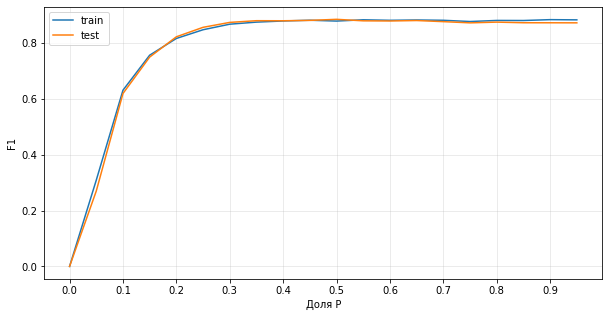

In [210]:
oy = [rate / iterations for rate in range(iterations)]

plt.figure(figsize=(10, 5))
plt.plot(oy, df2['train'], label='train')
plt.plot(oy, df2['test'], label='test')
plt.grid(alpha=0.3)
plt.xlabel('Доля P')
plt.ylabel('F1')
plt.legend(loc='best')
plt.xticks(oy[::2])
plt.show()

Таким образом можно видеть, что приблизительно на отметке $P=0.3$ значение F1 уже принимает достаточно высокое значение и этого объема размеченной выборки достаточно для качественного прогноза.